In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Mounted at /content/drive


In [2]:
# 2. Đọc file csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/DIG Historical Data 1_6.csv')

In [3]:
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df=df[::-1]
df1=df.reset_index()['Price']

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(len(df1)) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [9]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
16/16 [==============================] - 5s 94ms/step - loss: 0.0274 - val_loss: 0.0030
Epoch 2/100
16/16 [==============================] - 1s 63ms/step - loss: 0.0029 - val_loss: 4.7637e-04
Epoch 3/100
16/16 [==============================] - 1s 59ms/step - loss: 0.0012 - val_loss: 1.3446e-04
Epoch 4/100
16/16 [==============================] - 1s 61ms/step - loss: 6.8111e-04 - val_loss: 1.8208e-04
Epoch 5/100
16/16 [==============================] - 1s 63ms/step - loss: 5.8059e-04 - val_loss: 1.2627e-04
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 5.2309e-04 - val_loss: 1.2722e-04
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 5.3797e-04 - val_loss: 1.6339e-04
Epoch 8/100
16/16 [==============================] - 1s 61ms/step - loss: 5.0278e-04 - val_loss: 1.3256e-04
Epoch 9/100
16/16 [==============================] - 1s 73ms/step - loss: 4.7609e-04 - val_loss: 1.1305e-04
Epoch 10/100
16/16 [========================

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

12/12 [==============================] - 0s 15ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 22699.606480372822


In [14]:
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_pred, ytest)
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))*100
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing MAPE: 99.99913621969363
Testing MAE: 21940.747241178287


In [15]:
x_input = test_data[len(test_data)-time_step:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

print(lst_output)


[[0.22603276371955872], [0.22265388071537018], [0.21880780160427094], [0.21474497020244598], [0.21055454015731812], [0.20627091825008392], [0.2019088715314865], [0.19747544825077057], [0.19297440350055695], [0.18840795755386353], [0.1837773323059082], [0.17908303439617157], [0.17432521283626556], [0.16950340569019318], [0.1646169126033783], [0.1596647948026657], [0.15464583039283752], [0.14955872297286987], [0.1444019079208374], [0.13917380571365356], [0.13387271761894226], [0.12849685549736023], [0.12304436415433884], [0.11751333624124527], [0.11190178990364075], [0.10620775818824768], [0.10042919218540192], [0.09456396847963333], [0.08861001580953598], [0.08256519585847855], [0.07642729580402374], [0.07019416987895966], [0.06386358290910721], [0.05743329972028732], [0.050901077687740326], [0.04426465556025505], [0.03752176836133003], [0.030670136213302612], [0.023707490414381027], [0.016631558537483215], [0.009440076537430286], [0.002130796667188406], [-0.005298510193824768], [-0.012

In [16]:
future_predict = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
future_predict

array([[ 27297.50871725],
       [ 26987.98647754],
       [ 26635.66678518],
       [ 26263.4915209 ],
       [ 25879.62759566],
       [ 25487.22683921],
       [ 25087.64198575],
       [ 24681.51868947],
       [ 24269.20093523],
       [ 23850.89211093],
       [ 23426.70414815],
       [ 22996.68345756],
       [ 22560.84368934],
       [ 22119.14252791],
       [ 21671.51581734],
       [ 21217.87756142],
       [ 20758.11582855],
       [ 20292.11186206],
       [ 19819.7223349 ],
       [ 19340.80255502],
       [ 18855.19691021],
       [ 18362.74159815],
       [ 17863.26667392],
       [ 17356.59741505],
       [ 16842.55227394],
       [ 16320.95106806],
       [ 15791.60610722],
       [ 15254.32287618],
       [ 14708.91163723],
       [ 14155.1765101 ],
       [ 13592.9147894 ],
       [ 13021.92991235],
       [ 12442.01712603],
       [ 11852.97167755],
       [ 11254.58813148],
       [ 10646.65934613],
       [ 10028.97783856],
       [  9401.33476081],
       [  87

In [17]:
# Append the last 100 values of test_data to the beginning of y_pred
last_100_test_data = scaler.inverse_transform(test_data[:101])
y_pred_with_test_data = np.append(last_100_test_data, y_pred)

In [18]:
print(y_pred_with_test_data.shape)
test_data.shape

(480,)


(480, 1)

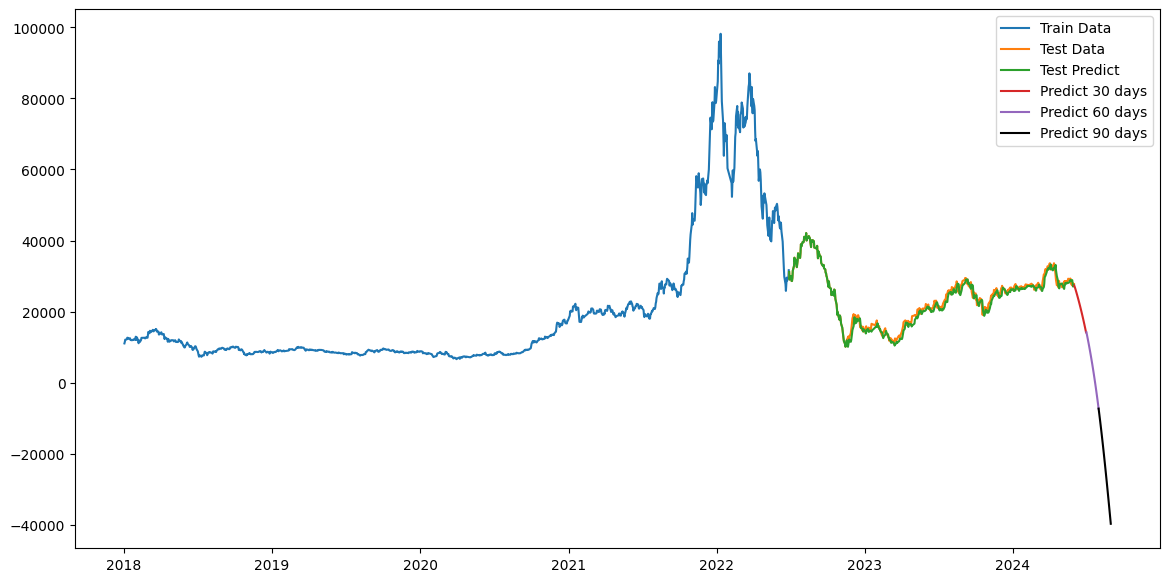

In [19]:
# Plot results
plt.figure(figsize=(14, 7))

# Plot train data
plt.plot(df['Date'][:train_size], scaler.inverse_transform(train_data), label='Train Data')

# Plot test data
plt.plot(df['Date'][train_size:], scaler.inverse_transform(test_data), label='Test Data')

# Plot test predict data with appended last 100 test data
plt.plot(df['Date'][train_size:train_size + len(y_pred_with_test_data)], y_pred_with_test_data, label='Test Predict')

# Plot future predictions
last_test_date = df['Date'].iloc[-1]
future_predict_dates = pd.date_range(start=last_test_date + pd.Timedelta(days=1), periods=30)
future_predict_dates_1 = pd.date_range(start=last_test_date + pd.Timedelta(days=31), periods=31)
future_predict_dates_2 = pd.date_range(start=last_test_date + pd.Timedelta(days=61), periods=31)

plt.plot(future_predict_dates, future_predict[0:30], label='Predict 30 days')
plt.plot(future_predict_dates_1, future_predict[29:60], label='Predict 60 days')
plt.plot(future_predict_dates_2, future_predict[59:90], label='Predict 90 days', color='black')
# Display the legend
plt.legend()

# Display the plot
plt.show()